<VSCode.Cell id="header" language="markdown">
```ascii
╔════════════════════════════════════════════════════════════════════════════╗
║                                                                            ║
║   ███████╗████████╗██████╗  █████╗ ████████╗███████╗ ██████╗ ██╗   ██╗     ║
║   ██╔════╝╚══██╔══╝██╔══██╗██╔══██╗╚══██╔══╝██╔════╝██╔════╝ ╚██╗ ██╔╝     ║
║   ███████╗   ██║   ██████╔╝███████║   ██║   █████╗  ██║  ███╗ ╚████╔╝      ║
║   ╚════██║   ██║   ██╔══██╗██╔══██║   ██║   ██╔══╝  ██║   ██║  ╚██╔╝       ║
║   ███████║   ██║   ██║  ██║██║  ██║   ██║   ███████╗╚██████╔╝   ██║        ║
║   ╚══════╝   ╚═╝   ╚═╝  ╚═╝╚═╝  ╚═╝   ╚═╝   ╚══════╝ ╚═════╝    ╚═╝        ║
║                                                                            ║
╚════════════════════════════════════════════════════════════════════════════╝

# ML-Based Trading Strategy Backtesting

This notebook implements and evaluates a machine learning-based trading strategy using historical market data and model predictions. The strategy combines technical indicators with ML predictions to generate trading signals.

## Key Features
- 🤖 ML-driven signal generation
- 📊 Comprehensive performance metrics
- 📈 Visual performance analysis
- 💰 Risk-adjusted returns calculation
- 🔄 Walk-forward testing

## Configuration
- Initial Capital: $5,000
- Position Size: 10% per trade
- Stop Loss: 2%
- Take Profit: 5%

*Last updated: May 2025*
</VSCode.Cell>

In [5]:
# Import dependencies and setup
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import joblib 
from src.backtesting.strategy import TradingStrategy
from src.backtesting.ml_strategy import MLStrategy
from src.backtesting.backtest import Backtest
from src.backtesting.metrics import calculate_performance_metrics




In [11]:
# Load configuration and generate Linear Regression predictions
with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Load feature data
try:
    all_features = pd.read_pickle('../data/processed/all_features.pkl')
    print("Successfully loaded features")
except FileNotFoundError as e:
    print(f"Error loading features: {e}")
    print("Please run feature engineering first")
    raise

# Get target symbol and periods
target_symbol = config['target_symbol']
strategy_period = config['periods']['strategy']

strategy_start = pd.to_datetime(strategy_period['start']).tz_localize('America/New_York')
strategy_end = pd.to_datetime(strategy_period['end']).tz_localize('America/New_York')

# Ensure all_features index is timezone-aware
if all_features.index.tz is None:
    all_features.index = all_features.index.tz_localize('America/New_York')

print(f"Analyzing strategy for {target_symbol}")
print(f"Strategy period: {strategy_start.strftime('%Y-%m-%d')} to {strategy_end.strftime('%Y-%m-%d')}")

# Filter features to strategy period using timezone-aware dates
strategy_mask = (all_features.index >= strategy_start) & (all_features.index <= strategy_end)
strategy_features = all_features[strategy_mask]
if strategy_features.empty:
    raise ValueError("No data available for strategy period")

print(f"Strategy features shape: {strategy_features.shape}")

# Load Linear Regression model and generate predictions
import pickle
import os

models_dir = '../models'

try:
    # Load model artifacts
    with open(os.path.join(models_dir, 'linear_regression_model.pkl'), 'rb') as f:
        lr_model = pickle.load(f)

    with open(os.path.join(models_dir, 'lr_feature_scaler.pkl'), 'rb') as f:
        feature_scaler = pickle.load(f)
        
    with open(os.path.join(models_dir, 'lr_target_scaler.pkl'), 'rb') as f:
        target_scaler = pickle.load(f)
        
    with open(os.path.join(models_dir, 'lr_selected_features.pkl'), 'rb') as f:
        selected_features = pickle.load(f)

    print(f"Loaded Linear Regression model with {len(selected_features)} selected features")

    # IMPORTANT: Use the same feature preparation as in training
    # Import the feature preparation function
    sys.path.append('../')
    from src.features.feature_model_prep import prepare_features, create_period_masks
    
    # Prepare features the exact same way as during training
    periods = config['periods']
    peer_symbols = config['peer_symbols']
    
    # Create period masks (even though we only need strategy)
    masks = create_period_masks(all_features, periods)
    
    # Prepare features with the same filtering as training
    X_full, y_full, feature_names = prepare_features(
        all_features, 
        target_symbol, 
        peer_symbols,
        config
    )
    
    # Extract strategy period data
    X_strategy = X_full[masks['strategy']]
    y_strategy = y_full[masks['strategy']]
    
    print(f"Prepared features shape: {X_strategy.shape}")
    print(f"Feature scaler expects {len(feature_scaler.feature_names_in_)} features")
    
    # Clean and prepare features the same way as training
    features_clean = X_strategy.copy()
    
    # Handle missing values the same way as training
    features_clean = features_clean.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # Scale features using the exact same column order as training
    features_scaled = pd.DataFrame(
        feature_scaler.transform(features_clean),
        index=features_clean.index,
        columns=features_clean.columns
    )
    
    # Select the same features used in training
    features_selected = features_scaled[selected_features]
    
    # Generate predictions
    predictions_scaled = lr_model.predict(features_selected)
    
    # Inverse transform to original scale
    lr_predictions = target_scaler.inverse_transform(
        predictions_scaled.reshape(-1, 1)
    ).ravel()
    
    # Create predictions series with proper index
    predictions = pd.Series(lr_predictions, index=features_clean.index)
    
    print(f"Generated {len(predictions)} Linear Regression predictions for strategy period")
    print(f"Prediction range: {predictions.min():.2f} to {predictions.max():.2f}")
    
    # Update strategy_features to use the properly prepared features
    strategy_features = X_strategy
    
except FileNotFoundError as e:
    print(f"Error loading Linear Regression model: {e}")
    print("Please run linear_regression_modeling.ipynb first to train the model")
    raise

# After loading predictions, add validation
print("\nTimeframe Analysis:")
print(f"Strategy period: {strategy_start} to {strategy_end}")
print(f"Predictions available: {predictions.index[0]} to {predictions.index[-1]}")
print(f"Features available: {all_features.index[0]} to {all_features.index[-1]}")

# Initialize strategy with config parameters
try:
    strategy = MLStrategy(
        initial_capital=config['backtesting']['initial_capital'],
        entry_threshold=config['backtesting']['entry_threshold'],
        exit_threshold=config['backtesting']['exit_threshold'],
        max_trades=config['backtesting']['max_trades']
    )
    print("Strategy initialized with parameters from config")
except KeyError as e:
    print(f"Error: Missing config parameter {e}")
    raise

# Update signal generation logic - need to get actual price data
# Load the original features to get price data
original_strategy_features = all_features[strategy_mask]

signal_check = pd.DataFrame({
    'price': original_strategy_features[f'{target_symbol}_Close'],
    'prediction': predictions,
    'predicted_return': (predictions - original_strategy_features[f'{target_symbol}_Close']) / original_strategy_features[f'{target_symbol}_Close']
})

signal_check['potential_entry'] = (
    signal_check['predicted_return'] > config['backtesting']['entry_threshold']
)
signal_check['potential_exit'] = (
    signal_check['predicted_return'] < config['backtesting']['exit_threshold']
)

print("\nSignal Analysis:")
print(f"Total potential entry signals: {signal_check['potential_entry'].sum()}")
print(f"Total potential exit signals: {signal_check['potential_exit'].sum()}")

# Show sample of signals
print("\nSample of potential trading signals:")
print(signal_check[signal_check['potential_entry'] | signal_check['potential_exit']].head())

# Verify data alignment before backtest
common_dates = original_strategy_features.index.intersection(predictions.index)
if len(common_dates) == 0:
    raise ValueError("No overlapping dates between predictions and features")

# Filter both datasets to common dates
strategy_features_for_backtest = original_strategy_features.loc[common_dates]
predictions_aligned = predictions.loc[common_dates]

print(f"Using {len(common_dates)} aligned trading days for backtest")

# Initialize and run backtest using predictions
backtest = Backtest(strategy=strategy, data=strategy_features_for_backtest)
results = backtest.run(predictions=predictions_aligned)

# Then calculate trade statistics
trade_count = len(results[results['position'] != results['position'].shift(1)]) // 2
print("\nTrade Statistics:")
print(f"Total Trades: {trade_count}")
print(f"Max Trades Allowed: {config['backtesting']['max_trades']}")

# Calculate and display metrics
metrics = calculate_performance_metrics(results)

# Display performance metrics
print("\nPerformance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate and display capital metrics
initial_capital = config['backtesting']['initial_capital']
final_capital = initial_capital * (1 + metrics['total_return'])

print("\nCapital Summary:")
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Capital:   ${final_capital:,.2f}")
print(f"Net Profit:     ${(final_capital - initial_capital):,.2f}")

Successfully loaded features
Analyzing strategy for MSFT
Strategy period: 2025-01-01 to 2025-06-01
Strategy features shape: (102, 1924)
Loaded Linear Regression model with 40 selected features
Prepared features shape: (102, 885)
Feature scaler expects 885 features
Generated 102 Linear Regression predictions for strategy period
Prediction range: 244.37 to 488.89

Timeframe Analysis:
Strategy period: 2025-01-01 00:00:00-05:00 to 2025-06-01 00:00:00-04:00
Predictions available: 2025-01-02 00:00:00-05:00 to 2025-05-30 00:00:00-04:00
Features available: 2020-01-02 00:00:00-05:00 to 2025-05-30 00:00:00-04:00
Strategy initialized with parameters from config

Signal Analysis:
Total potential entry signals: 0
Total potential exit signals: 102

Sample of potential trading signals:
                                price  prediction  predicted_return  \
Date                                                                  
2025-01-02 00:00:00-05:00  416.976868  487.630037          0.169441   
2025-

C:\Users\Kenrm\AppData\Local\Temp\ipykernel_55348\1796031838.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_clean = features_clean.fillna(method='ffill').fillna(method='bfill').fillna(0)


C:\Users\Kenrm\AppData\Local\Temp\ipykernel_55348\3204184547.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = results['strategy_returns'].resample('M').sum()


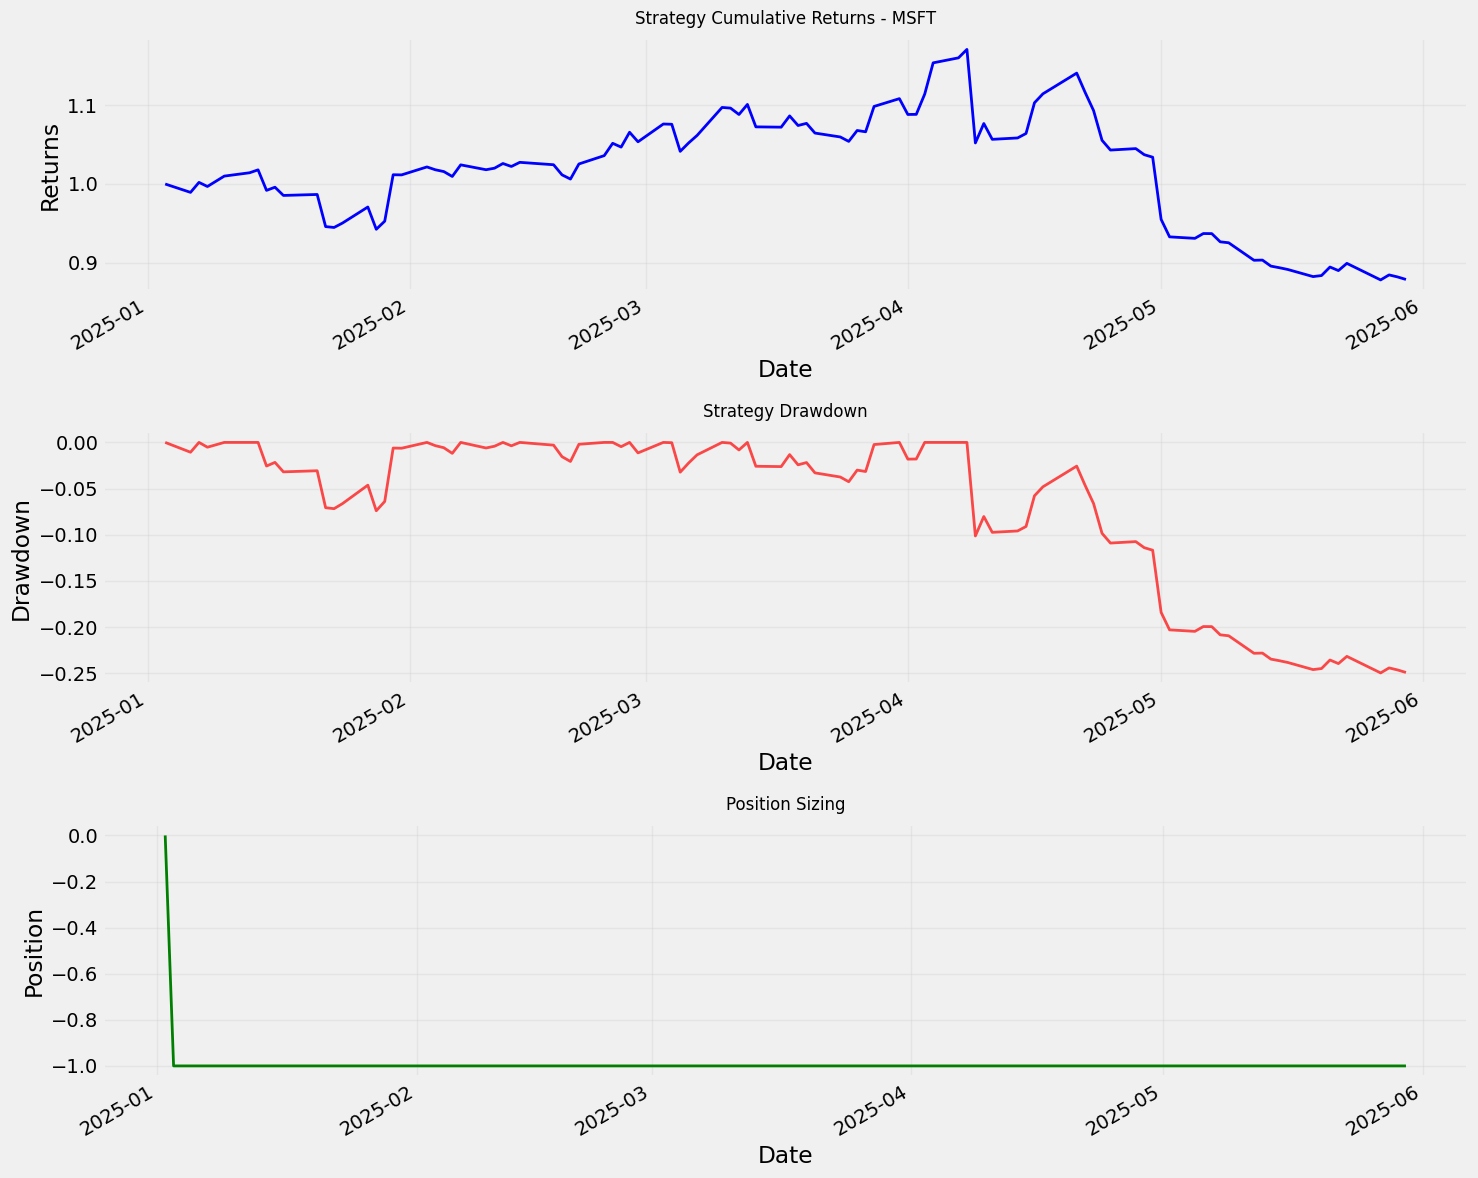

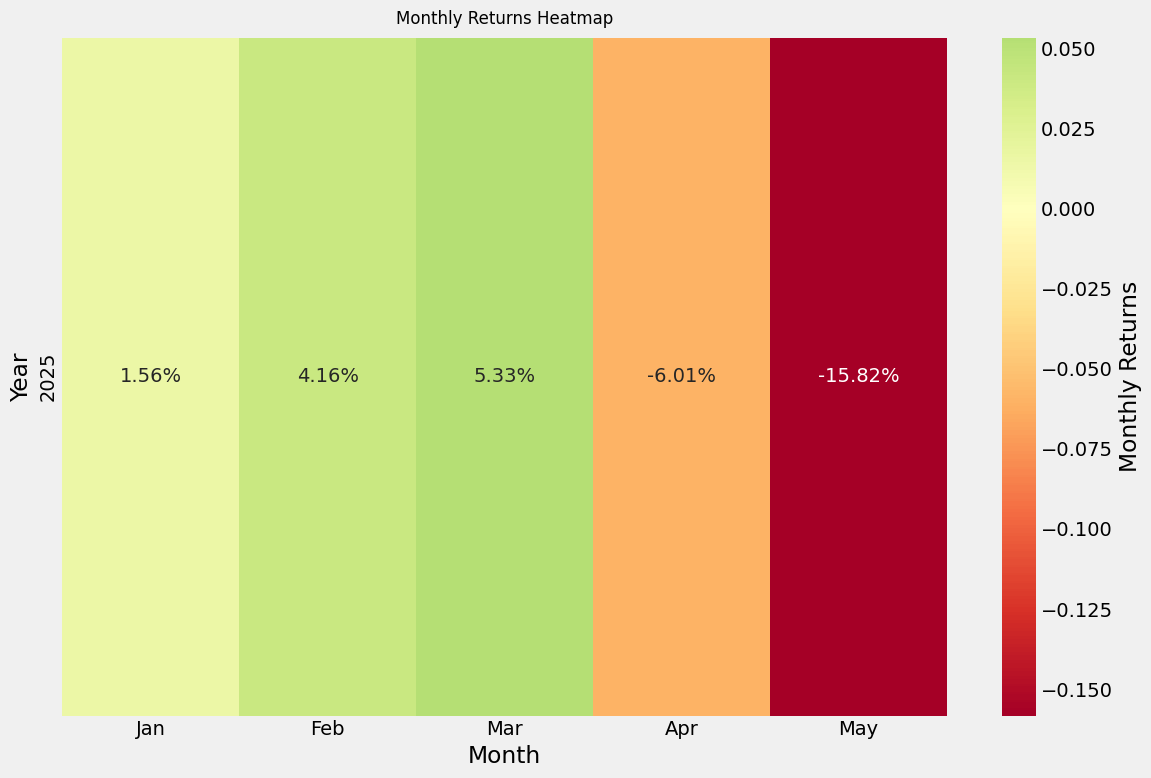

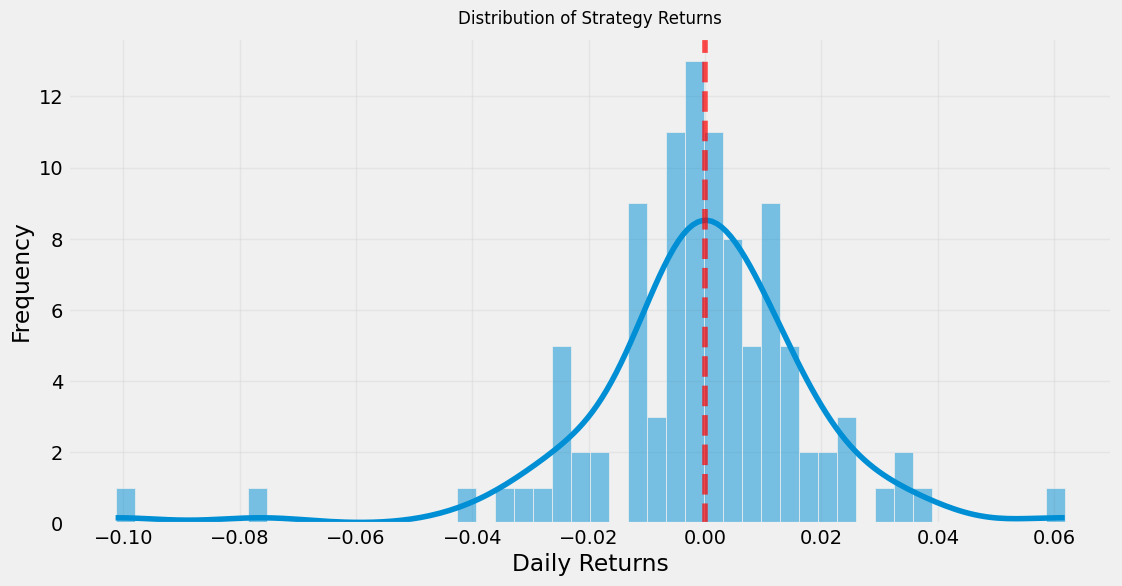

In [12]:
# Create monthly returns table for heatmap
monthly_returns = results['strategy_returns'].resample('M').sum()
monthly_returns_df = pd.DataFrame(monthly_returns)
monthly_returns_pivot = pd.pivot_table(
    monthly_returns_df,
    index=monthly_returns_df.index.year,
    columns=monthly_returns_df.index.month,
    values='strategy_returns'
)

# Set visualization style
plt.style.use('fivethirtyeight')

# Create performance visualization subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Cumulative Returns
results['cumulative_returns'].plot(ax=ax1, color='blue', linewidth=2)
ax1.set_title(f'Strategy Cumulative Returns - {target_symbol}', fontsize=12, pad=10)
ax1.set_ylabel('Returns')
ax1.grid(True, alpha=0.3)

# Plot 2: Drawdown
results['drawdown'].plot(ax=ax2, color='red', linewidth=2, alpha=0.7)
ax2.set_title('Strategy Drawdown', fontsize=12, pad=10)
ax2.set_ylabel('Drawdown')
ax2.grid(True, alpha=0.3)

# Plot 3: Position Sizing
results['position'].plot(ax=ax3, color='green', linewidth=2)
ax3.set_title('Position Sizing', fontsize=12, pad=10)
ax3.set_ylabel('Position')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Monthly returns heatmap
plt.figure(figsize=(12, 8))

# Get actual months present in the data
months_present = sorted(monthly_returns_pivot.columns)
month_labels = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Create heatmap with actual data
ax = sns.heatmap(
    monthly_returns_pivot,
    annot=True, 
    fmt='.2%', 
    center=0,
    cmap='RdYlGn',
    cbar_kws={'label': 'Monthly Returns'}
)

# Set correct labels
ax.set_xticklabels([month_labels[m] for m in months_present], rotation=0)

plt.title('Monthly Returns Heatmap', fontsize=12, pad=10)
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

# Return distribution analysis
plt.figure(figsize=(12, 6))
sns.histplot(data=results['strategy_returns'], bins=50, kde=True)
plt.title('Distribution of Strategy Returns', fontsize=12, pad=10)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.show()